# /r/wallstreetbets Reddit Analysis


# Summary:

The objective of this script is to determine if /r/wallstreetbets was a culprit in the astronomic rise in certain "meme" stocks. We will use Topic modeling to determine which were relevant daily topics, and map the probability of Target Stock Topics vs the Stock Price. We will explore less common stocks to see if our topic models are accurate beyond the meme stocks


### Import Libraries

In [1]:
# load modules
from pyspark.sql import SparkSession
import os
from datetime import date, timedelta
import datetime as dt
from pyspark.sql.functions import udf
from pyspark.sql.functions import countDistinct
import pandas as pd
from pyspark.sql.functions import abs
from datetime import datetime
from pyspark.sql import functions as f
from  pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from pyspark.sql import types as t
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from pyspark.ml.feature import StringIndexer
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
import nltk
from pyspark.sql import SQLContext
nltk.download('stopwords') #need this for stopwords
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.clustering import LDA, LocalLDAModel,DistributedLDAModel
#Set Size of plots
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import lower, col
from pandas.tseries.offsets import BDay
from pathlib import Path
import math
import shutil
import pickle
from matplotlib.pyplot import figure
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/tnx7bh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#shutil.rmtree('/project/ds5559/group8_Reddit/GME_Daily_TopicDistribution')

# Data Preperation and Setup

We will be doing this following in this section

1. Setup Combine our Comments Files, and Aggregate all comments on a Daily Basis
2. Setup our Stock Historical Data. This will allow us to experiment with various stocks against our Model


### Create Spark Instance

PLEASE NOTE if you are running this in a different directory than the original, change this Path_Directory

In [3]:
PATH_DIRECTORY = '/project/ds5559/group8_Reddit/'

spark = SparkSession \
    .builder \
    .appName("WSB") \
    .getOrCreate()

schema = StructType([ \
    StructField("Subreddit",StringType(),True), \
    StructField("Create_Date",DoubleType(),True), \
    StructField("Title",StringType(),True), \
    StructField("Comment", StringType(), True), \
  ])


sc = spark.sparkContext
sqlContext = SQLContext(sc)

### Read in Comments from reddit wsb

WSB Comments were done in chunks as the files were very large and the API takes a long time to collect the data
The Total Comments 

In [4]:
#WSB Comments
###########################
wsb_comments_file = PATH_DIRECTORY + "wallstreetbets_2021_first_half.csv"

wsb_comments = spark.read.csv(wsb_comments_file, schema=schema, header = True, sep='|')

wsb_comments_file_2 = PATH_DIRECTORY + "wallstreetbets_2021_Second_Half.csv"

wsb_comments_2 = spark.read.csv(wsb_comments_file_2, schema=schema, header = True, sep='|')

wsb_comments = wsb_comments.union(wsb_comments_2)
################################


#NASDAQ Files
################################
nasdaq_stocks_file = PATH_DIRECTORY + "nasdaqtraded.csv"

other_exchanges_stocks_file = PATH_DIRECTORY + "otherExchanges.csv"

nasdaq_stocks = spark.read.csv(nasdaq_stocks_file, header = True, sep='|')

other_exchanges_stocks = spark.read.csv(other_exchanges_stocks_file, header = True, sep='|')
################################


In [5]:
wsb_comments.show(2)

+--------------+-------------+--------------------+--------------------+
|     Subreddit|  Create_Date|               Title|             Comment|
+--------------+-------------+--------------------+--------------------+
|wallstreetbets|1.609578399E9|The Dummy's guide...|I am just long sp...|
|wallstreetbets|1.609578399E9|The Dummy's guide...|I'm shorting Bets...|
+--------------+-------------+--------------------+--------------------+
only showing top 2 rows



### Set Up Stock History

We Can graph the stocks history against our model findings

In [6]:
#Combine Stock Data

customSchema = StructType([ \
StructField("Date", StringType(), True), \
StructField("Open", DoubleType(), True), \
StructField("High", DoubleType(), True), \
StructField("Low", DoubleType(), True), \
StructField("Close", DoubleType(), True), \
StructField("Adj Close", DoubleType(), True), \
StructField("Volume", DoubleType(), True), \
StructField("filename", StringType(), True)])


fullpath = PATH_DIRECTORY + 'Stock_History/*.csv'

Path('/root/dir/sub/file.ext').stem
stock_history = spark.read.format("csv") \
   .option("header", "true") \
   .option("sep",",") \
   .schema(customSchema) \
   .load(fullpath) \
   .withColumn("filename", input_file_name())

## NASDAQ Stock Symbol Lookup

We can use this to lookup the number of stocks available in our Directory

In [7]:
all_stocks = nasdaq_stocks.select("Symbol").union(other_exchanges_stocks.select("NASDAQ Symbol").distinct())

all_stocks = all_stocks.withColumn("Symbol",f.lower(f.col("Symbol")))

all_stocks = all_stocks.distinct()

all_stocks.show(2)

+------+
|Symbol|
+------+
| akicu|
|  alxo|
+------+
only showing top 2 rows



### Parsing Stock By Finding it In the CSV Filename

#### ATTENTION. I am finding the Stock name using the specific path in the server. If moved, we must changed the "getItem" length to the desired path length

In [8]:
FilenameExample = stock_history.select("filename").collect()[0]['filename'] #We are getting the First Value of the Filepath to get the last value....for example ('file:/project/ds5559/group8_Reddit/Stock_History/FAST.csv') We want to parse out FAST as the stock name
NumberofSlashes = FilenameExample.count('/') #We need to find how many slashes there are to get the last one
stock_history = stock_history.withColumn('stock', f.split(stock_history['filename'], '/').getItem(NumberofSlashes)) \
    .withColumn('stock', f.lower(f.col('stock'))) \
    .withColumn('stock', f.split(f.col('stock'), '\.').getItem(0)) \
    .drop("filename")

In [9]:
print("Number of Historical Stock Rows = ",stock_history.count())

stock_history.select("*").filter(stock_history.stock == "gme").show(4,)

Number of Historical Stock Rows =  69580
+----------+---------+---------+-----+---------+---------+---------+-----+
|      Date|     Open|     High|  Low|    Close|Adj Close|   Volume|stock|
+----------+---------+---------+-----+---------+---------+---------+-----+
|2021-01-04|     19.0|     19.1|17.15|    17.25|    17.25|1.00225E7|  gme|
|2021-01-05|    17.35|    18.08|17.23|17.370001|17.370001|4961500.0|  gme|
|2021-01-06|    17.34|    18.98|17.33|18.360001|18.360001|6056200.0|  gme|
|2021-01-07|18.469999|19.450001|18.02|    18.08|    18.08|6129300.0|  gme|
+----------+---------+---------+-----+---------+---------+---------+-----+
only showing top 4 rows



### Lets Get The Raw Counts of our Reddit Comments File

In [10]:
wsb_comments.show(5)
print("Number of Comments = ",wsb_comments.count())


+--------------+-------------+--------------------+--------------------+
|     Subreddit|  Create_Date|               Title|             Comment|
+--------------+-------------+--------------------+--------------------+
|wallstreetbets|1.609578399E9|The Dummy's guide...|I am just long sp...|
|wallstreetbets|1.609578399E9|The Dummy's guide...|I'm shorting Bets...|
|wallstreetbets|1.609578399E9|The Dummy's guide...|Great DD but I ca...|
|wallstreetbets|1.609578399E9|The Dummy's guide...|No weed plays? Weak.|
|wallstreetbets|1.609578399E9|The Dummy's guide...|UVXY 11c 1/15 see...|
+--------------+-------------+--------------------+--------------------+
only showing top 5 rows

Number of Comments =  4668909


### Convert UNIX Time to YYYY/MM/DD

This will be useful when matching up daily comments to our Stock Historical Data

In [11]:
#Changing Datetime from unix to a python datetime
wsb_comments = wsb_comments.withColumn('Create_Datetime', f.date_format(wsb_comments.Create_Date.cast(dataType=t.TimestampType()), "yyyy-MM-dd"))

#Getting WordCounts for each comment
wsb_comments = wsb_comments.withColumn('wordCount', f.size(f.split(f.col('Comment'), ' ')))
wsb_comments.show(2)

+--------------+-------------+--------------------+--------------------+---------------+---------+
|     Subreddit|  Create_Date|               Title|             Comment|Create_Datetime|wordCount|
+--------------+-------------+--------------------+--------------------+---------------+---------+
|wallstreetbets|1.609578399E9|The Dummy's guide...|I am just long sp...|     2021-01-02|       15|
|wallstreetbets|1.609578399E9|The Dummy's guide...|I'm shorting Bets...|     2021-01-02|        9|
+--------------+-------------+--------------------+--------------------+---------------+---------+
only showing top 2 rows



### Aggregate All Comments on a Daily Basis

In [12]:
#This is if we want to create a single bucket per Date
wsb_comments_final = wsb_comments.groupby("Create_Datetime").agg(f.concat_ws(" ", f.collect_list(wsb_comments.Comment)))

wsb_comments_final= wsb_comments_final.withColumnRenamed("concat_ws( , collect_list(Comment))", "Comment").sort(wsb_comments_final.Create_Datetime.asc()).filter(wsb_comments_final.Create_Datetime != "null")

#Creating an Index per Day to Eventually Join with Our Final Table Results
wsb_comments_final_dates_With_Index = wsb_comments_final.select("Create_Datetime").rdd.zipWithIndex().toDF(['Create_Datetime', 'date_index'])

In [13]:
wsb_comments_final.show(3)

+---------------+--------------------+
|Create_Datetime|             Comment|
+---------------+--------------------+
|     2021-01-02|I am just long sp...|
|     2021-01-03|Why does his iPho...|
|     2021-01-04|This post was fla...|
+---------------+--------------------+
only showing top 3 rows



In [14]:
wsb_comments_final.select("Create_Datetime").summary("count","min","max").show()

+-------+---------------+
|summary|Create_Datetime|
+-------+---------------+
|  count|            272|
|    min|     2021-01-02|
|    max|     2021-10-18|
+-------+---------------+



# MODEL CREATION (Latent Dirichlet Allocation)

We will do the following in this section

1. Set up TFIDF Table (Term frequency * Inverse Document Frequency) Table
2. Create 10 Models using different Hyper Parameters
    i. Total allowed topics ranging from 30 to 130 incrementing by 10
      

In [15]:
#This allows us to convert a numeric value of a word back to its original text for interpretability
def topic_render(topic, row):
    terms = topic[row][1]
#    print(terms)
    result = []
    for i in range(len(terms)):
        term = Total_Vocab[terms[i]]
        result.append(term)
    return result

## Comments Filtering and TFIDF Table Creation
#### Time takes around 6 minutes to complete

We will try to modify one hyperparameter: minDF

**The User Can Change the minDF to either 1 or 10 for previously made Topic Models. minDF = 10 has shown to be the best results**

minDF Description: This gives a lower bound on words which do not exist in at least N number of documents. Raising this could potentially help the LDA model focus on commonly used words in the subreddit
We discovered better results when raising up the minDF to 10 so we will focus mostly expanding on this hyperparameter setting


In [16]:
%%time
StopWords = stopwords.words("english")
#Additional mentions of "ford" actually mean the stock "F", not the Stock ticker FORD
CustomStopWords = ['submission', 'submissions', 'characters']

#Filter
wsb_comments_RDD = wsb_comments_final.rdd
Comment = wsb_comments_RDD.map(lambda x : x['Comment']).filter(lambda x: x is not None)
tokens = Comment                                                   \
                .map( lambda document: document.strip().lower())           \
                .map( lambda document: re.split(" ", document))        \
                .map( lambda word: [x for x in word if x.isalpha()])          \
                .map( lambda word: [x for x in word if len(x) > 2 ] )         \
                .map( lambda word: [x for x in word if x not in StopWords])   \
                .map( lambda word: [x for x in word if x not in CustomStopWords])   \
                .zipWithIndex()

#TFIDF Table Creation

df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])
try:
        # TF
    minDF = 10 # Adjust To either 1 or 10 For pre-run Models
    cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=7000, minDF=minDF)
    #change minDF to Any Number 1 or above to test new TFIDF Tables
    cvmodel = cv.fit(df_txts)
    result_cv = cvmodel.transform(df_txts)
    # IDF
    idf = IDF(inputCol="raw_features", outputCol="features")
    idfModel = idf.fit(result_cv)
    result_tfidf = idfModel.transform(result_cv) 
    Total_Vocab = cvmodel.vocabulary
    result_tfidf_final = result_tfidf.select("index","features")
    print("Created TFIDF")

except:
    print("Something went Wrong")


Created TFIDF
CPU times: user 108 ms, sys: 37.4 ms, total: 146 ms
Wall time: 6min 15s


## Main Loop For LDA Model
Warning: This takes time if you do not have previously created models (WSB_LDA_MODEL_130, WSB_LDA_MODEL_120....etc). Please load these previously made models to speed up the waiting time.

1. Check to See if we already created the model
2. If not Create LDA Model with Desired Total Topics

In [17]:
#LDA
for num_topics in range(30, 131, 10):
    print("Generating LDA With", num_topics, "Topics")
        # Lets see if the Model Already Exists To Save Time
    modelpath = PATH_DIRECTORY + r'/TFIDF_MIN_DF_' + str(minDF) + '/MODELS/WSB_LDA_MODEL_' + str(num_topics)
    if not os.path.exists(modelpath):
        os.makedirs(modelpath)

    if len(os.listdir(modelpath)) == 0: 
        print("Creating LDA....")
        lda = LDA(k=num_topics, seed=314, optimizer="em", topicDistributionCol='topicDistribution')
        model = lda.fit(result_tfidf_final)
        model = model.toLocal()
        model.save(modelpath + '/full_model')


Generating LDA With 30 Topics
Generating LDA With 40 Topics
Generating LDA With 50 Topics
Generating LDA With 60 Topics
Generating LDA With 70 Topics
Generating LDA With 80 Topics
Generating LDA With 90 Topics
Generating LDA With 100 Topics
Generating LDA With 110 Topics
Generating LDA With 120 Topics
Generating LDA With 130 Topics


### A Closer Look at Topic Distribution

Lets take a look at the Topic Probability distribution for a Day To Vizualize how LDA has transformed our TFIDF table.
We will now have a DenseVector that contains the probability that each topic is being discussed.

You can skip over this Cell. This is just Informational. Total Run time around 3 minutes

In [18]:
%%time
modelpath = PATH_DIRECTORY + r'/TFIDF_MIN_DF_' + str(minDF) + '/MODELS/WSB_LDA_MODEL_' + str(30)
model = LocalLDAModel.load(modelpath + '/full_model') #load in Model Created
Test_Stock = model.transform(result_tfidf)
Test_Stock_With_CreateDate = Test_Stock.join(wsb_comments_final_dates_With_Index, col('index') == col('date_index'),'inner')
Topics_Dist = Test_Stock_With_CreateDate.select("Create_Datetime", "topicDistribution").collect()
print("Printing The 5th Day's Probability Distribution For our 30 Total Topics Model")
print(Topics_Dist[5][1])
print("")
print("")
print("Every Day Should Sum Up To 1 (100%)", sum(Topics_Dist[5][1]))


Printing The 5th Day's Probability Distribution For our 30 Total Topics Model
[0.008286213231848187,0.0023884758934596593,0.005315223553337606,0.014317924977736951,0.2581903790811437,0.008183499183215502,0.0028779825800440122,0.0022165480985525854,0.0065279006250638545,0.007857694162842013,0.0011447762398692281,0.005202469748599102,0.0037729523468625938,0.005879190232426811,0.008234110430821555,0.010488880983171984,0.10988812223289225,0.00474113611654719,0.0047121136505599535,0.006167886519724737,0.01149668032235518,0.008669226765297527,0.004908760468055811,0.003914119498436767,0.005120971767555808,0.16273605720289971,0.0063468645706660975,0.30905137916516,0.0037499587606555766,0.0076125015901980795]


Every Day Should Sum Up To 1 (100%) 1.0
CPU times: user 63.7 ms, sys: 21.6 ms, total: 85.4 ms
Wall time: 3min 30s


# Bucket Topics Based on Discovered Stock


We will now identify all topics that involve our target stock.
ex. If a topic has "gme" in it, we will bucket it in the GME Dataframe Lookup Table

### GME

All Topics that have "gme" 

In [19]:
columns = ['Total_Topics','Topic_Number']
Lda_Topics_schema = StructType([
StructField("Total_Topics", IntegerType(), True), \
StructField("Topic_Number", IntegerType(), True), 
  ])

GME_Topic_DF = spark.sparkContext.emptyRDD()
GME_Topic_DF = spark.createDataFrame(GME_Topic_DF,Lda_Topics_schema)


for num_topics in range(30, 131, 10):
    # Lets see if the Model Already Exists To Save Time
    modelpath = PATH_DIRECTORY + r'/TFIDF_MIN_DF_' + str(minDF) + '/MODELS/WSB_LDA_MODEL_' + str(num_topics)  
    model = LocalLDAModel.load(modelpath + '/full_model') #load in Model Created
    topicIndices = model.describeTopics().collect()
    all_words_all_topics = []
    for i in range(0,len(topicIndices)):
        result = topic_render(topicIndices, i)
#        all_words_all_topics = all_words_all_topics + result
        if "gme" in result:
            print(result)
            newRow = spark.createDataFrame([(num_topics,i)], columns)
            GME_Topic_DF = GME_Topic_DF.union(newRow)


    
    
    
    #Check if any words appear in the NASDAQ/Exchanges       
    #print("Topic", i, result)
#   all_words_all_topics = list(set(all_words_all_topics))

GME_Topic_DF.show()

['citron', 'shitron', 'melvin', 'cohen', 'misused', 'gme', 'livestream', 'tweet', 'ryan', 'tomorrow']
['citron', 'shitron', 'melvin', 'cohen', 'misused', 'livestream', 'gme', 'tweet', 'ryan', 'tomorrow']
['citron', 'shitron', 'melvin', 'cohen', 'misused', 'livestream', 'gme', 'ryan', 'tweet', 'shorts']
['rkt', 'megathread', 'ssr', 'hedgies', 'ɴᴏᴡ', 'jim', 'hodl', 'gme', 'dfv', 'apes']
['rkt', 'ssr', 'gme', 'megathread', 'bruce', 'tomorrow', 'hedgies', 'dip', 'iborrowdesk', 'melvin']
['citron', 'shitron', 'melvin', 'cohen', 'livestream', 'gme', 'ryan', 'misused', 'tweet', 'moass']
['amc', 'eod', 'gme', 'tomorrow', 'win', 'pltr', 'shares', 'spy', 'squeeze', 'dip']
['citron', 'shitron', 'melvin', 'cohen', 'misused', 'gme', 'livestream', 'ryan', 'moass', 'bla']
['rkt', 'ssr', 'megathread', 'bruce', 'hodl', 'hedgies', 'spy', 'gme', 'distraction', 'thread']
['rkt', 'megathread', 'ɴᴏᴡ', 'gme', 'hedgies', 'ssr', 'hodl', 'jim', 'hedgie', 'cramer']
['misused', 'flaired', 'notified', 'melvin', 'c

### AMC

All Topics that have "amc"

In [20]:
columns = ['Total_Topics','Topic_Number']
Lda_Topics_schema = StructType([
StructField("Total_Topics", IntegerType(), True), \
StructField("Topic_Number", IntegerType(), True), 
  ])

AMC_Topic_DF = spark.sparkContext.emptyRDD()
AMC_Topic_DF = spark.createDataFrame(AMC_Topic_DF,Lda_Topics_schema)


for num_topics in range(30, 131, 10):
    # Lets see if the Model Already Exists To Save Time
    modelpath = PATH_DIRECTORY + r'/TFIDF_MIN_DF_' + str(minDF) + '/MODELS/WSB_LDA_MODEL_' + str(num_topics)  
    model = LocalLDAModel.load(modelpath + '/full_model') #load in Model Created
    topicIndices = model.describeTopics().collect()
    all_words_all_topics = []
    for i in range(0,len(topicIndices)):
        result = topic_render(topicIndices, i)
#        all_words_all_topics = all_words_all_topics + result
        if "amc" in result:
            newRow = spark.createDataFrame([(num_topics,i)], columns)
            AMC_Topic_DF = AMC_Topic_DF.union(newRow)


    
    
    
    #Check if any words appear in the NASDAQ/Exchanges       
    #print("Topic", i, result)
#   all_words_all_topics = list(set(all_words_all_topics))

AMC_Topic_DF.show()

+------------+------------+
|Total_Topics|Topic_Number|
+------------+------------+
|          30|           7|
|          30|          10|
|          40|           5|
|          40|           9|
|          40|          15|
|          40|          26|
|          40|          29|
|          40|          31|
|          50|           1|
|          50|           7|
|          50|          12|
|          50|          13|
|          50|          21|
|          50|          36|
|          50|          44|
|          50|          47|
|          60|           4|
|          60|           5|
|          60|          29|
|          60|          37|
+------------+------------+
only showing top 20 rows



# SOFI

All Topics that have "sofi"

In [21]:
columns = ['Total_Topics','Topic_Number']
Lda_Topics_schema = StructType([
StructField("Total_Topics", IntegerType(), True), \
StructField("Topic_Number", IntegerType(), True), 
  ])

SOFI_Topic_DF = spark.sparkContext.emptyRDD()
SOFI_Topic_DF = spark.createDataFrame(SOFI_Topic_DF,Lda_Topics_schema)


for num_topics in range(30, 131, 10):
    # Lets see if the Model Already Exists To Save Time
    modelpath = PATH_DIRECTORY + r'/TFIDF_MIN_DF_' + str(minDF) + '/MODELS/WSB_LDA_MODEL_' + str(num_topics)  
    model = LocalLDAModel.load(modelpath + '/full_model') #load in Model Created
    topicIndices = model.describeTopics().collect()
    all_words_all_topics = []
    for i in range(0,len(topicIndices)):
        result = topic_render(topicIndices, i)
#        all_words_all_topics = all_words_all_topics + result
        if "sofi" in result:
  
            newRow = spark.createDataFrame([(num_topics,i)], columns)
            SOFI_Topic_DF = SOFI_Topic_DF.union(newRow)


    
    
    
    #Check if any words appear in the NASDAQ/Exchanges       
    #print("Topic", i, result)
#   all_words_all_topics = list(set(all_words_all_topics))

SOFI_Topic_DF.show()

+------------+------------+
|Total_Topics|Topic_Number|
+------------+------------+
|          30|           3|
|          30|           5|
|          30|           8|
|          30|          14|
|          30|          15|
|          30|          18|
|          30|          19|
|          30|          28|
|          40|           1|
|          40|           4|
|          40|           6|
|          40|          12|
|          40|          13|
|          40|          21|
|          40|          22|
|          40|          23|
|          40|          24|
|          40|          28|
|          40|          33|
|          40|          36|
+------------+------------+
only showing top 20 rows



# Palantir

All Topics that have "pltr"

In [22]:
columns = ['Total_Topics','Topic_Number']
Lda_Topics_schema = StructType([
StructField("Total_Topics", IntegerType(), True), \
StructField("Topic_Number", IntegerType(), True), 
  ])

PLTR_Topic_DF = spark.sparkContext.emptyRDD()
PLTR_Topic_DF = spark.createDataFrame(PLTR_Topic_DF,Lda_Topics_schema)


for num_topics in range(30, 31, 10):
    # Lets see if the Model Already Exists To Save Time
    modelpath = PATH_DIRECTORY + r'/TFIDF_MIN_DF_' + str(minDF) + '/MODELS/WSB_LDA_MODEL_' + str(num_topics)  
    model = LocalLDAModel.load(modelpath + '/full_model') #load in Model Created
    topicIndices = model.describeTopics().collect()
    all_words_all_topics = []
    for i in range(0,len(topicIndices)):
        result = topic_render(topicIndices, i)

#        all_words_all_topics = all_words_all_topics + result
        if "pltr" in result:
            print(result)
  
            newRow = spark.createDataFrame([(num_topics,i)], columns)
            PLTR_Topic_DF = PLTR_Topic_DF.union(newRow)


    
    
    
    #Check if any words appear in the NASDAQ/Exchanges       
    #print("Topic", i, result)
#   all_words_all_topics = list(set(all_words_all_topics))

PLTR_Topic_DF.show()

['spy', 'puts', 'clov', 'rkt', 'pltr', 'mrvi', 'coin', 'megathread', 'calls', 'green']
['rkt', 'discb', 'ssr', 'spy', 'megathread', 'disca', 'pltr', 'hodl', 'ɴᴏᴡ', 'hedgies']
['amc', 'spy', 'pltr', 'clov', 'tlry', 'crsr', 'uwmc', 'puts', 'eod', 'calls']
['tsla', 'nio', 'spy', 'pltr', 'georgia', 'tesla', 'baba', 'puts', 'dems', 'calls']
['tsla', 'ipoe', 'psth', 'spy', 'tesla', 'baba', 'nio', 'pltr', 'puts', 'aapl']
+------------+------------+
|Total_Topics|Topic_Number|
+------------+------------+
|          30|           2|
|          30|           6|
|          30|           7|
|          30|           9|
|          30|          21|
+------------+------------+



#### Get Stock Topics Function

Description: This function returns a nice list of all the topic numbers from the dataframes created above.

In [23]:
def Get_Stock_Topics(dataframe, topic_number):
    only_stock_topics = dataframe.filter(dataframe["Total_Topics"] == topic_number).select("Topic_Number")
    topic_indexes = only_stock_topics.select('Topic_Number').rdd.flatMap(lambda x: x).collect()
    return topic_indexes
    

#### Get Probabilities Function

Description: This function takes in our main TDFIF Table, Takes in the Total Topic Number, the Stocks Topic Dataframe (created above), and the name of the Stock we are analyzing

It will go through the discovered topics, and sum up the total daily probability that people are discussing the target stock. We store each value in a parquet file that will be used at a later point.

In [24]:
def Get_Daily_Probabilities(result_tfidf, topic_number, Stock_Topic_DF, stock_name):
    columns = ['Create_Datetime','Probability']
    Resulting_Topic_DF_schema = StructType([
    StructField("Create_Datetime", StringType(), True), \
    StructField("Probability", FloatType(), True), 
      ])
    
    modelpath = PATH_DIRECTORY + r'WSB_LDA_MODEL_' + str(topic_number)
    model = LocalLDAModel.load(modelpath + '/full_model') #load in Model Created
    Test_Stock = model.transform(result_tfidf)
    Test_Stock_With_CreateDate = Test_Stock.join(wsb_comments_final_dates_With_Index, col('index') == col('date_index'),'inner')
    Topics_Dist = Test_Stock_With_CreateDate.select("Create_Datetime", "topicDistribution").collect()
    list_stock_topics = Get_Stock_Topics(Stock_Topic_DF, topic_number)
    for i in range(0, len(Topics_Dist)):
        total_Stock_Probability = 0
        Create_Datetime = Topics_Dist[i][0][0]
        for topic_index in list_stock_topics:
            total_Stock_Probability = float(total_Stock_Probability) + float(Topics_Dist[i][1][topic_index])
        newRow = spark.createDataFrame([(Create_Datetime,float(total_Stock_Probability))], schema = Resulting_Topic_DF_schema)
        newRow.write.csv(path= PATH_DIRECTORY + stock_name + "_Daily_TopicDistribution/", mode="append")
            #Resulting_Topic_DF = Resulting_Topic_DF.union(newRow)

    return 0

# Grab Probabilities of GME Topics Per Day

In [25]:
modelpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/GME' + "_Daily_TopicDistribution/"
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
if len(os.listdir(modelpath)) == 0: 
    for num_topic in range(30, 131, 10):
        Get_Daily_Probabilities(result_tfidf, num_topic, GME_Topic_DF, "GME")
        print("Completed",num_topic,"Topic")



# Grab Probabilities of AMC Topics Per Day

In [26]:
modelpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/AMC' + "_Daily_TopicDistribution/"
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
if len(os.listdir(modelpath)) == 0: 
    for num_topic in range(30, 131, 10):
        Get_Daily_Probabilities(result_tfidf, num_topic, AMC_Topic_DF,"AMC")
        print("Completed",num_topic,"Topic")

# Grab Probabilities of SOFI Topics Per Day

In [27]:
modelpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/SOFI' + "_Daily_TopicDistribution/"
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
if len(os.listdir(modelpath)) == 0: 
    for num_topic in range(30, 131, 10):
        Get_Daily_Probabilities(result_tfidf, num_topic, SOFI_Topic_DF,"SOFI")
        print("Completed",num_topic,"Topic")

# Grab Probabilities of Palantir Topics Per Day

In [28]:
modelpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/PLTR' + "_Daily_TopicDistribution/"
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
if len(os.listdir(modelpath)) == 0: 
    for num_topic in range(30, 131, 10):
        Get_Daily_Probabilities(result_tfidf, num_topic, PLTR_Topic_DF,"PLTR")
        print("Completed",num_topic,"Topic")

# Collect Probabilities For All Topic Models

The Directorys below have the Daily probabilities for all models on a daily basis. We will load this into a dataframe to eventually average the daily probability for the target stock

In [29]:
customSchema = StructType([ \
StructField("Create_Datetime", StringType(), True), \
StructField("Probability", DoubleType(), True)])


GME_fullpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/' +  'GME_Daily_TopicDistribution/*.csv'
Path('/root/dir/sub/file.ext').stem


GME_Daily_Topic_DF = spark.read.format("csv") \
   .option("header", "false") \
   .option("sep",",") \
   .schema(customSchema) \
   .load(GME_fullpath)
         

AMC_fullpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/' + 'AMC_Daily_TopicDistribution/*.csv'

AMC_Daily_Topic_DF = spark.read.format("csv") \
   .option("header", "false") \
   .option("sep",",") \
   .schema(customSchema) \
   .load(AMC_fullpath)         
         
SOFI_fullpath = PATH_DIRECTORY + '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/' + 'SOFI_Daily_TopicDistribution/*.csv'



SOFI_Daily_Topic_DF = spark.read.format("csv") \
   .option("header", "false") \
   .option("sep",",") \
   .schema(customSchema) \
   .load(SOFI_fullpath)   



         
PLTR_fullpath = PATH_DIRECTORY +  '/TFIDF_MIN_DF_' + str(minDF) + '/Topic_Distributions/' + 'PLTR_Daily_TopicDistribution/*.csv'


PLTR_Daily_Topic_DF = spark.read.format("csv") \
   .option("header", "false") \
   .option("sep",",") \
   .schema(customSchema) \
   .load(PLTR_fullpath)       


         



# Get The Average Daily Probability

In [30]:
#GME
GME_Daily_Topic_DF_final = GME_Daily_Topic_DF.groupby("Create_Datetime").agg(f.mean('Probability'))
GME_Daily_Topic_DF_final= GME_Daily_Topic_DF_final.withColumnRenamed("avg(Probability)", "Probability").sort(GME_Daily_Topic_DF.Create_Datetime.asc())

#AMC
AMC_Daily_Topic_DF_final = AMC_Daily_Topic_DF.groupby("Create_Datetime").agg(f.mean('Probability'))
AMC_Daily_Topic_DF_final= AMC_Daily_Topic_DF_final.withColumnRenamed("avg(Probability)", "Probability").sort(AMC_Daily_Topic_DF.Create_Datetime.asc())

#SOFI
SOFI_Daily_Topic_DF_final = SOFI_Daily_Topic_DF.groupby("Create_Datetime").agg(f.mean('Probability'))
SOFI_Daily_Topic_DF_final= SOFI_Daily_Topic_DF_final.withColumnRenamed("avg(Probability)", "Probability").sort(SOFI_Daily_Topic_DF.Create_Datetime.asc())

#PLTR
PLTR_Daily_Topic_DF_final = PLTR_Daily_Topic_DF.groupby("Create_Datetime").agg(f.mean('Probability'))
PLTR_Daily_Topic_DF_final= PLTR_Daily_Topic_DF_final.withColumnRenamed("avg(Probability)", "Probability").sort(PLTR_Daily_Topic_DF.Create_Datetime.asc())



#### Convert To Pandas Dataframe
I have found its easier to plot if the dataframe is pandas as opposed to Pyspark

In [31]:
#GME
GME_Daily_Topic_DF_final_pd = GME_Daily_Topic_DF_final.toPandas()
#AMC
AMC_Daily_Topic_DF_final_pd = AMC_Daily_Topic_DF_final.toPandas()
#SOFI
SOFI_Daily_Topic_DF_final_pd = SOFI_Daily_Topic_DF_final.toPandas()
#PLTR
PLTR_Daily_Topic_DF_final_pd = PLTR_Daily_Topic_DF_final.toPandas()



#### Filtering For only Business days. Weekend discussions decrease significantly

In [32]:
#Lets look at only business days
isBusinessDay = BDay().is_on_offset
businessday = pd.to_datetime(GME_Daily_Topic_DF_final_pd['Create_Datetime']).map(isBusinessDay)

GME_Daily_Topic_DF_final_pd['Date'] = pd.to_datetime(GME_Daily_Topic_DF_final_pd['Create_Datetime'])

AMC_Daily_Topic_DF_final_pd['Date'] = pd.to_datetime(AMC_Daily_Topic_DF_final_pd['Create_Datetime'])

SOFI_Daily_Topic_DF_final_pd['Date'] = pd.to_datetime(SOFI_Daily_Topic_DF_final_pd['Create_Datetime'])

PLTR_Daily_Topic_DF_final_pd['Date'] = pd.to_datetime(PLTR_Daily_Topic_DF_final_pd['Create_Datetime'])



GME_Daily_Topic_DF_final_pd = GME_Daily_Topic_DF_final_pd[businessday]
AMC_Daily_Topic_DF_final_pd = AMC_Daily_Topic_DF_final_pd[businessday]
SOFI_Daily_Topic_DF_final_pd = SOFI_Daily_Topic_DF_final_pd[businessday]
PLTR_Daily_Topic_DF_final_pd = PLTR_Daily_Topic_DF_final_pd[businessday]


In [33]:
GME_STOCK = pd.read_csv(PATH_DIRECTORY + 'Stock_History/GME.csv')
GME_STOCK['Date'] = pd.to_datetime(GME_STOCK['Date'])

AMC_STOCK = pd.read_csv(PATH_DIRECTORY + 'Stock_History/AMC.csv')
AMC_STOCK['Date'] = pd.to_datetime(AMC_STOCK['Date'])


SOFI_STOCK = pd.read_csv(PATH_DIRECTORY+ 'Stock_History/SOFI.csv')
SOFI_STOCK['Date'] = pd.to_datetime(SOFI_STOCK['Date'])

PLTR_STOCK = pd.read_csv(PATH_DIRECTORY + 'Stock_History/PLTR.csv')
PLTR_STOCK['Date'] = pd.to_datetime(PLTR_STOCK['Date'])



## GME Plot

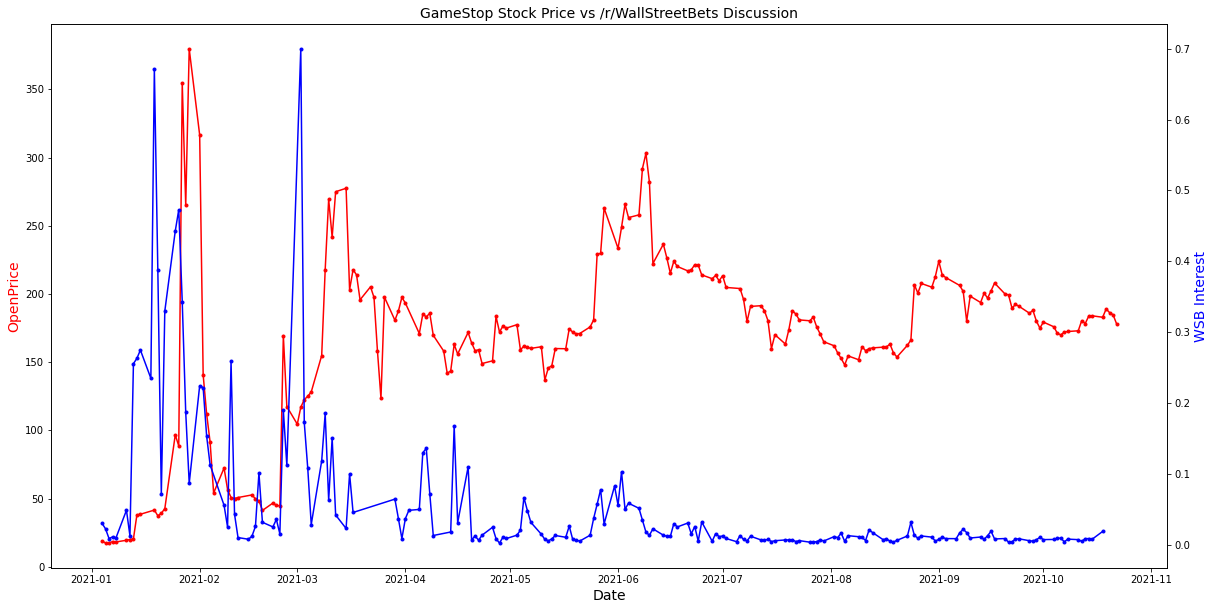

In [34]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(GME_STOCK.Date, GME_STOCK.Open, color="red", marker=".")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("OpenPrice",color="red",fontsize=14)

ax.set_title('GameStop Stock Price vs /r/WallStreetBets Discussion',
             fontsize = 14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(GME_Daily_Topic_DF_final_pd.Date, GME_Daily_Topic_DF_final_pd["Probability"],color="blue",marker=".")
ax2.set_ylabel("WSB Interest",color="blue",fontsize=14)

plt.gcf().set_size_inches(20, 10)
plt.savefig(PATH_DIRECTORY + 'GME_PLOT.png',dpi=200)
plt.show()

# save the plot as a file



## AMC Plot

There appears to be a gradual rise in discussions as the price of the stock increases

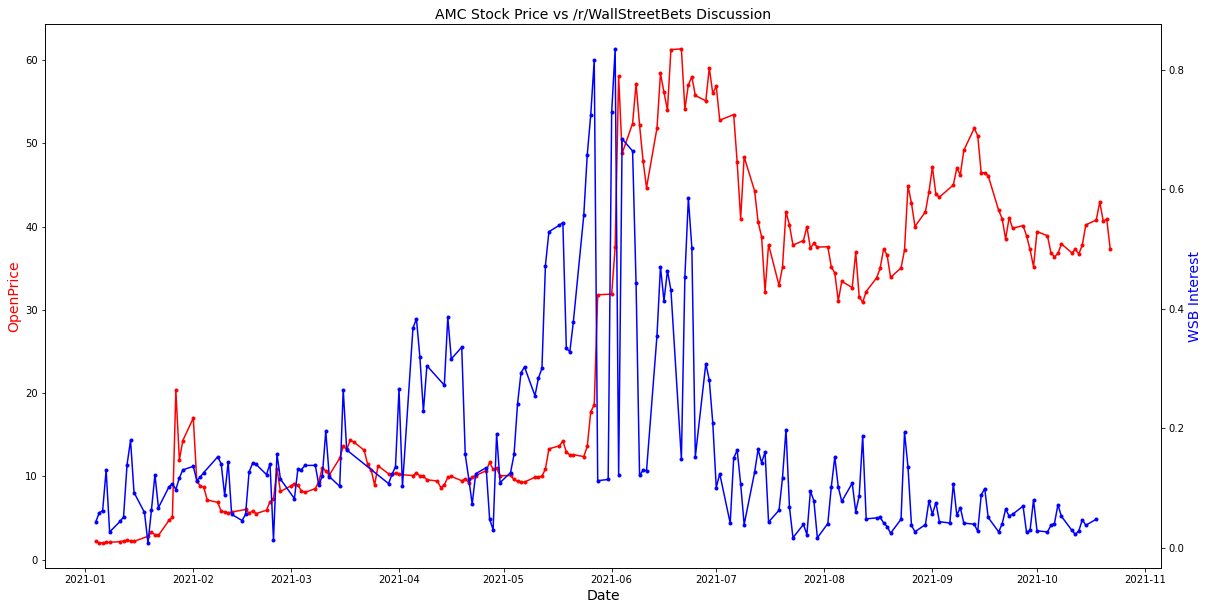

In [35]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(AMC_STOCK.Date, AMC_STOCK.Open, color="red", marker=".")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("OpenPrice",color="red",fontsize=14)

ax.set_title('AMC Stock Price vs /r/WallStreetBets Discussion',
             fontsize = 14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(AMC_Daily_Topic_DF_final_pd.Date, AMC_Daily_Topic_DF_final_pd["Probability"],color="blue",marker=".")
ax2.set_ylabel("WSB Interest",color="blue",fontsize=14)
plt.gcf().set_size_inches(20, 10)
plt.savefig(PATH_DIRECTORY + 'AMC_PLOT.png',dpi=200)
plt.show()

# save the plot as a file


## SOFI

We can see discussions rise and fall with the stock price, however it appears to be as lagging indicator. 

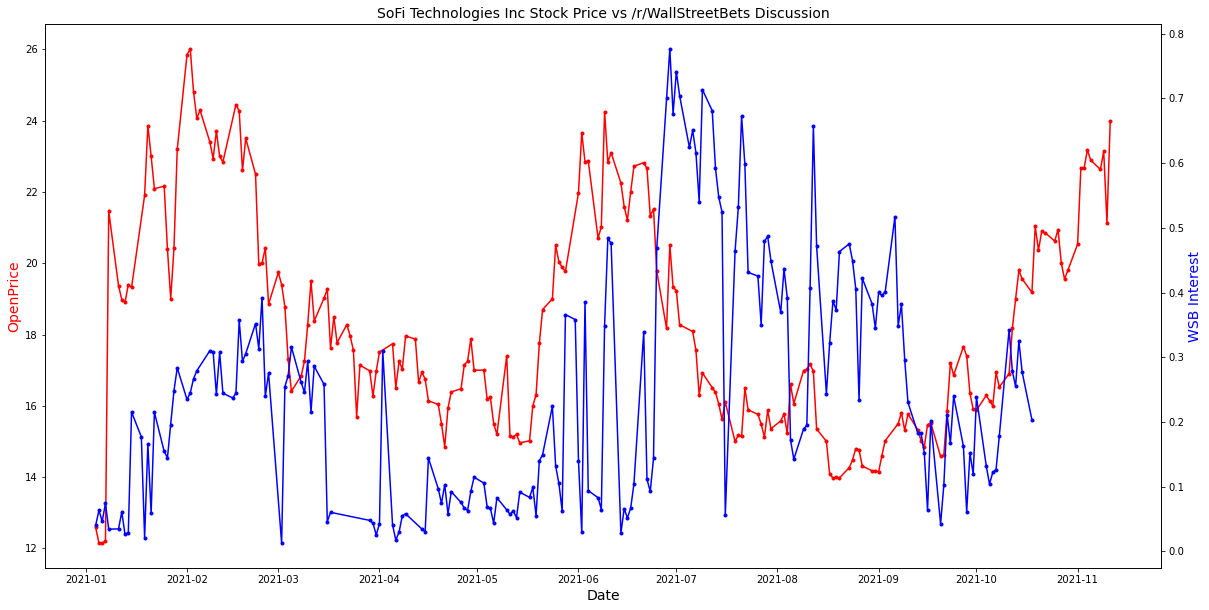

In [36]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(SOFI_STOCK.Date, SOFI_STOCK.Open, color="red", marker=".")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("OpenPrice",color="red",fontsize=14)

ax.set_title('SoFi Technologies Inc Stock Price vs /r/WallStreetBets Discussion',
             fontsize = 14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(SOFI_Daily_Topic_DF_final_pd.Date, SOFI_Daily_Topic_DF_final_pd["Probability"],color="blue",marker=".")
ax2.set_ylabel("WSB Interest",color="blue",fontsize=14)
plt.savefig(PATH_DIRECTORY + 'SOFI_PLOT.png',dpi=200)
plt.gcf().set_size_inches(20, 10)
plt.show()

# save the plot as a file


# Palantir 

There appears to be a large spike when there is not an increase in volatity. This is likely due to Palantir stocks being coupled with AMC. AMC around this time started to gain traction. This is likely a false positive in discussions about PLTR

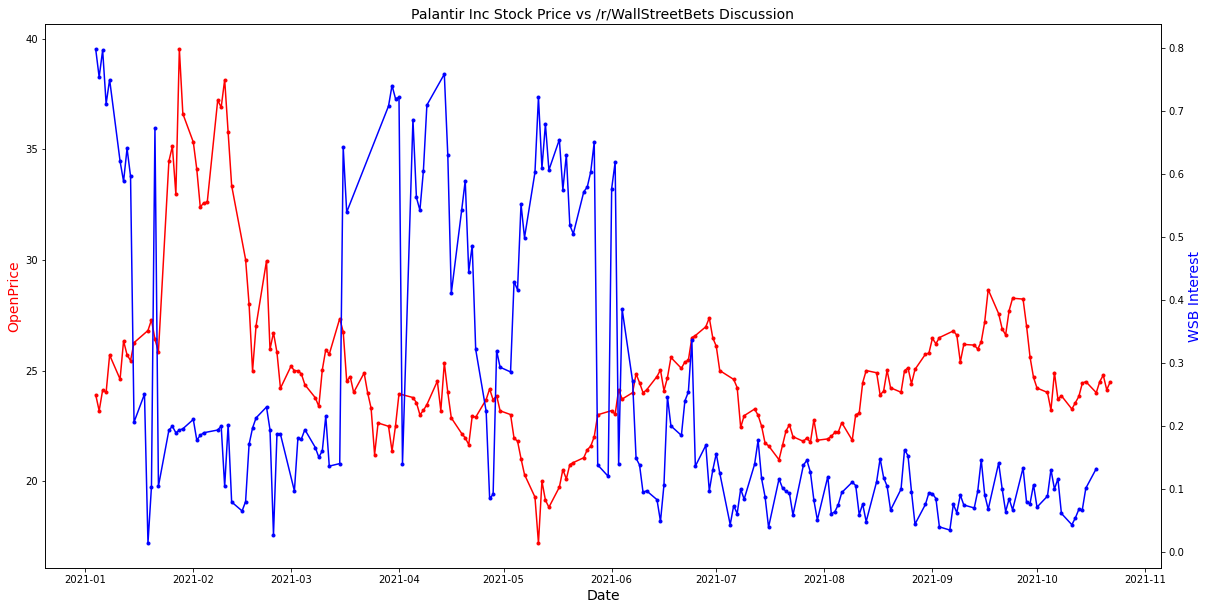

In [37]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(PLTR_STOCK.Date, PLTR_STOCK.Open, color="red", marker=".")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("OpenPrice",color="red",fontsize=14)

ax.set_title('Palantir Inc Stock Price vs /r/WallStreetBets Discussion',
             fontsize = 14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(PLTR_Daily_Topic_DF_final_pd.Date, PLTR_Daily_Topic_DF_final_pd["Probability"],color="blue",marker=".")
ax2.set_ylabel("WSB Interest",color="blue",fontsize=14)
plt.gcf().set_size_inches(20, 10)
plt.savefig(PATH_DIRECTORY+ 'PLTR_PLOT.png',dpi=200)
plt.show()

# save the plot as a file


# Reflections

The Models seem to accurately predict large events such as GME and AMC, finding the relevant topics that coincide with the change in stock price
However, its clear that there is a limit to model predicition of topics due to the coupling of stocks (PLTR + AMC). There is clearly noise when parting from major events, and the model seems to predict less accurate information as the topics get smaller
